In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
with open("representative_strains.json", "r") as f:
    representative_data = json.load(f)
    
phyla = dict()

for phylum, info in representative_data.items():
    if info["phylum_size"] > 2:
        phyla[info["representative_strain"]+".xml"] = phylum

In [4]:
micro_veg = pd.read_csv(r"results\24-04-2025-15-37-22_vegetarian\24-04-2025-15-37-22_vegetarian_large_intestine_microbiome.csv").fillna(0)
micro_keto = pd.read_csv(r"results\24-04-2025-22-26-07_keto\24-04-2025-22-26-07_keto_large_intestine_microbiome.csv").fillna(0)
meta_veg = pd.read_csv(r"results\24-04-2025-15-37-22_vegetarian\24-04-2025-15-37-22_vegetarian_large_intestine_metabolome.csv").fillna(0)
meta_keto = pd.read_csv(r"results\24-04-2025-22-26-07_keto\24-04-2025-22-26-07_keto_large_intestine_metabolome.csv").fillna(0)

dfs = [micro_veg, micro_keto, meta_veg, meta_keto]

for df in dfs[:2]:
    
    df["Unnamed: 0"] = df["Unnamed: 0"].apply(lambda x: phyla[x])
    df.rename(columns={"Unnamed: 0": "Phyla"}, inplace=True)
    df.set_index("Phyla", inplace=True)

for df in dfs[2:]:
    
    df.rename(columns={"Unnamed: 0": "Metabolites"}, inplace=True)
    df.set_index("Metabolites", inplace=True)
    df[df < 0] = 0

meta_veg = meta_veg.loc[~(meta_veg==0).all(axis=1)]
meta_keto = meta_keto.loc[~(meta_keto==0).all(axis=1)]

In [5]:
def plot_cell_counts(df, diet, window=7):
    
    plt.figure(figsize=(10, 6), dpi=150)

    roll_df = df.T.rolling(window=window).mean().dropna().T

    for species in range(len(roll_df)):

        plt.plot(roll_df.columns.astype(int)//24, roll_df.iloc[species], label=roll_df.index[species])
        
    plt.yscale("log")
    plt.xlabel("Time (days)")
    plt.ylabel("Number of Cells")
    plt.title(f"Microbiome growth - {diet} diet - {window} day rolling average")
    plt.legend(bbox_to_anchor = (1.05, 1))
    plt.show()

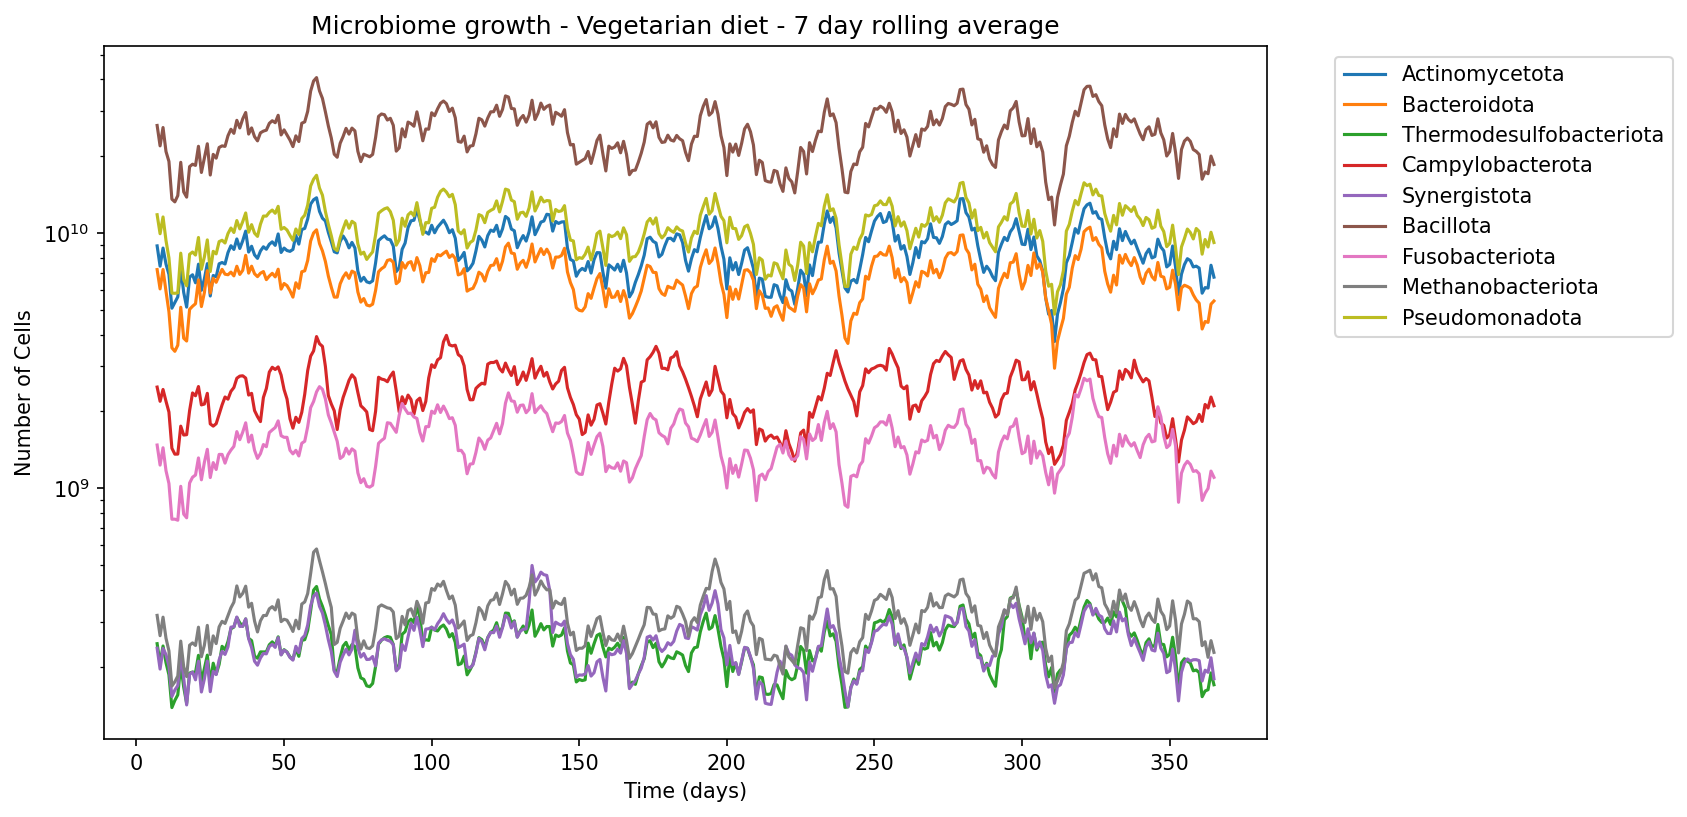

In [6]:
plot_cell_counts(micro_veg, "Vegetarian")

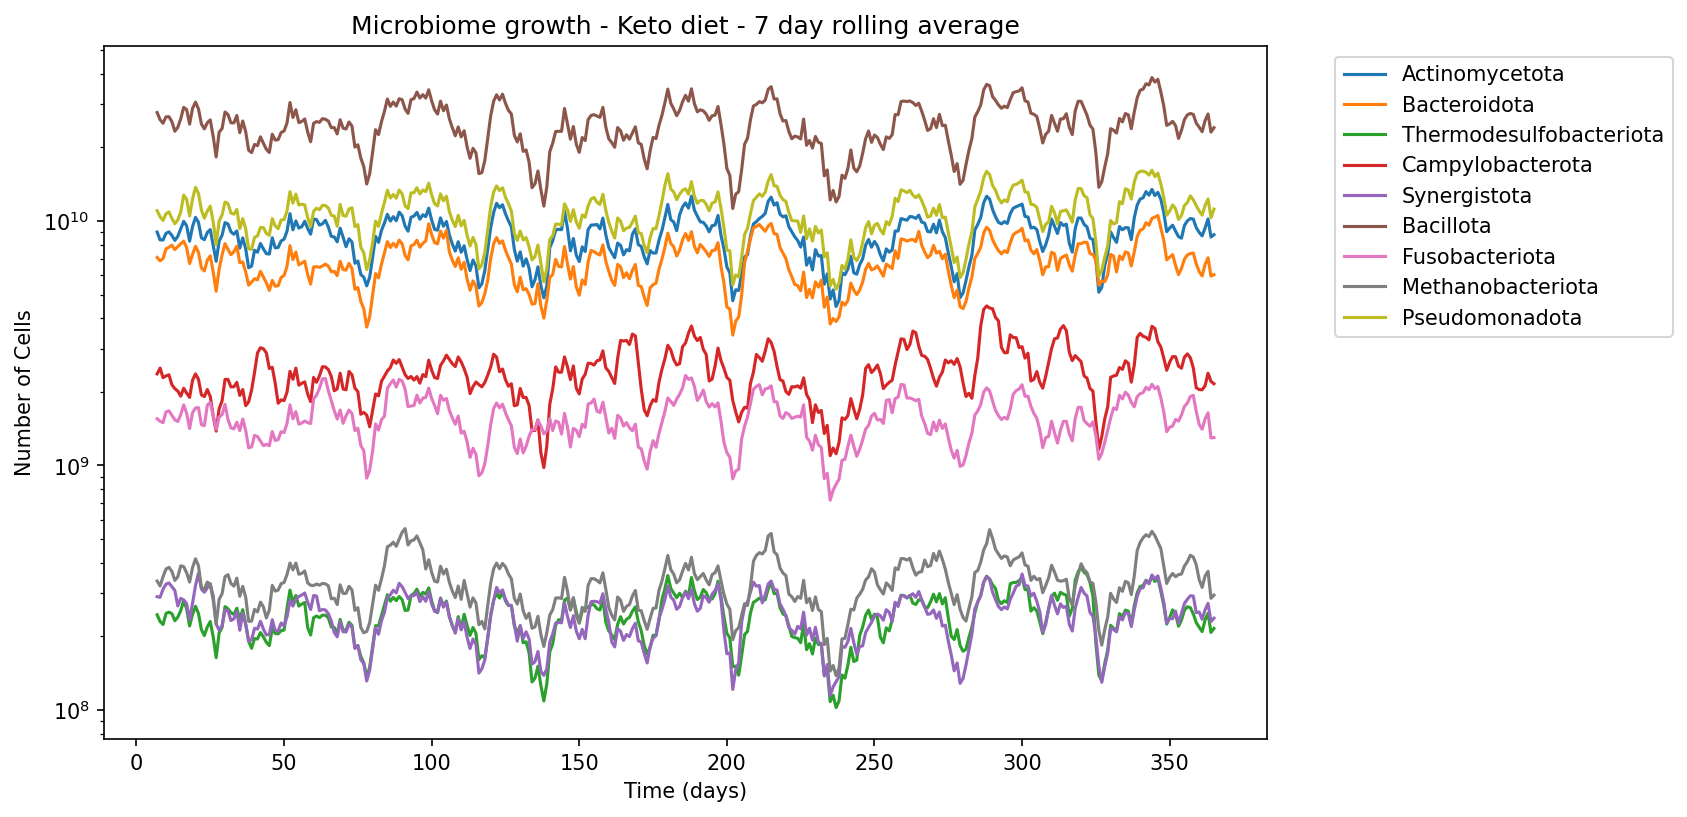

In [7]:
plot_cell_counts(micro_keto, "Keto")

In [8]:
def plot_monthly_growth_rates(df, diet):
    
    log_counts = np.log(df + 1)
    growth_rates = log_counts.diff(axis=1) / 24

    days_per_month = 31
    month_bins = np.arange(df.shape[1]) // days_per_month
    growth_rates.columns = month_bins

    avg_growth_per_month = growth_rates.groupby(axis=1, by=growth_rates.columns).mean()
    
    fig, ax = plt.subplots(figsize=(14, 6), dpi=150)

    species = avg_growth_per_month.index.tolist()
    months = avg_growth_per_month.columns.tolist()
    bar_width = 0.8 / len(species)  

    for i, sp in enumerate(species):
        ax.bar(
            np.array(months) + i * bar_width,
            avg_growth_per_month.loc[sp],
            width=bar_width,
            label=sp
        )

    ax.set_xlabel('Month')
    ax.set_ylabel('Average growth rate\n(per hour)')
    ax.set_title(f'Average monthly growth rates - {diet} Diet')
    ax.set_xticks(np.array(months) + bar_width * (len(species) / 2))
    ax.set_xticklabels([f'Month {m+1}' for m in months], rotation=45)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
    
    return avg_growth_per_month.dropna(axis=1)

In [9]:
def compare_growth_rates(avg_growth_veg, avg_growth_keto, alpha=0.05):
    
    results = []
    
    for species in avg_growth_veg.index:
        veg_values = avg_growth_veg.loc[species].values
        keto_values = avg_growth_keto.loc[species].values
        
        t_stat, p_val = ttest_ind(veg_values, keto_values, equal_var=False)  
        
        results.append({
            'Species': species,
            'Mean Growth (Vegetarian)': veg_values.mean(),
            'Mean Growth (Keto)': keto_values.mean(),
            'Std. Dev. Growth (Vegetarian)': veg_values.std(),
            'Std. Dev. Growth (Keto)': keto_values.std(),
            'p-value': p_val,
            'Significant': p_val < alpha
        })
    
    return pd.DataFrame(results).sort_values('p-value').reset_index().drop("index", axis=1)

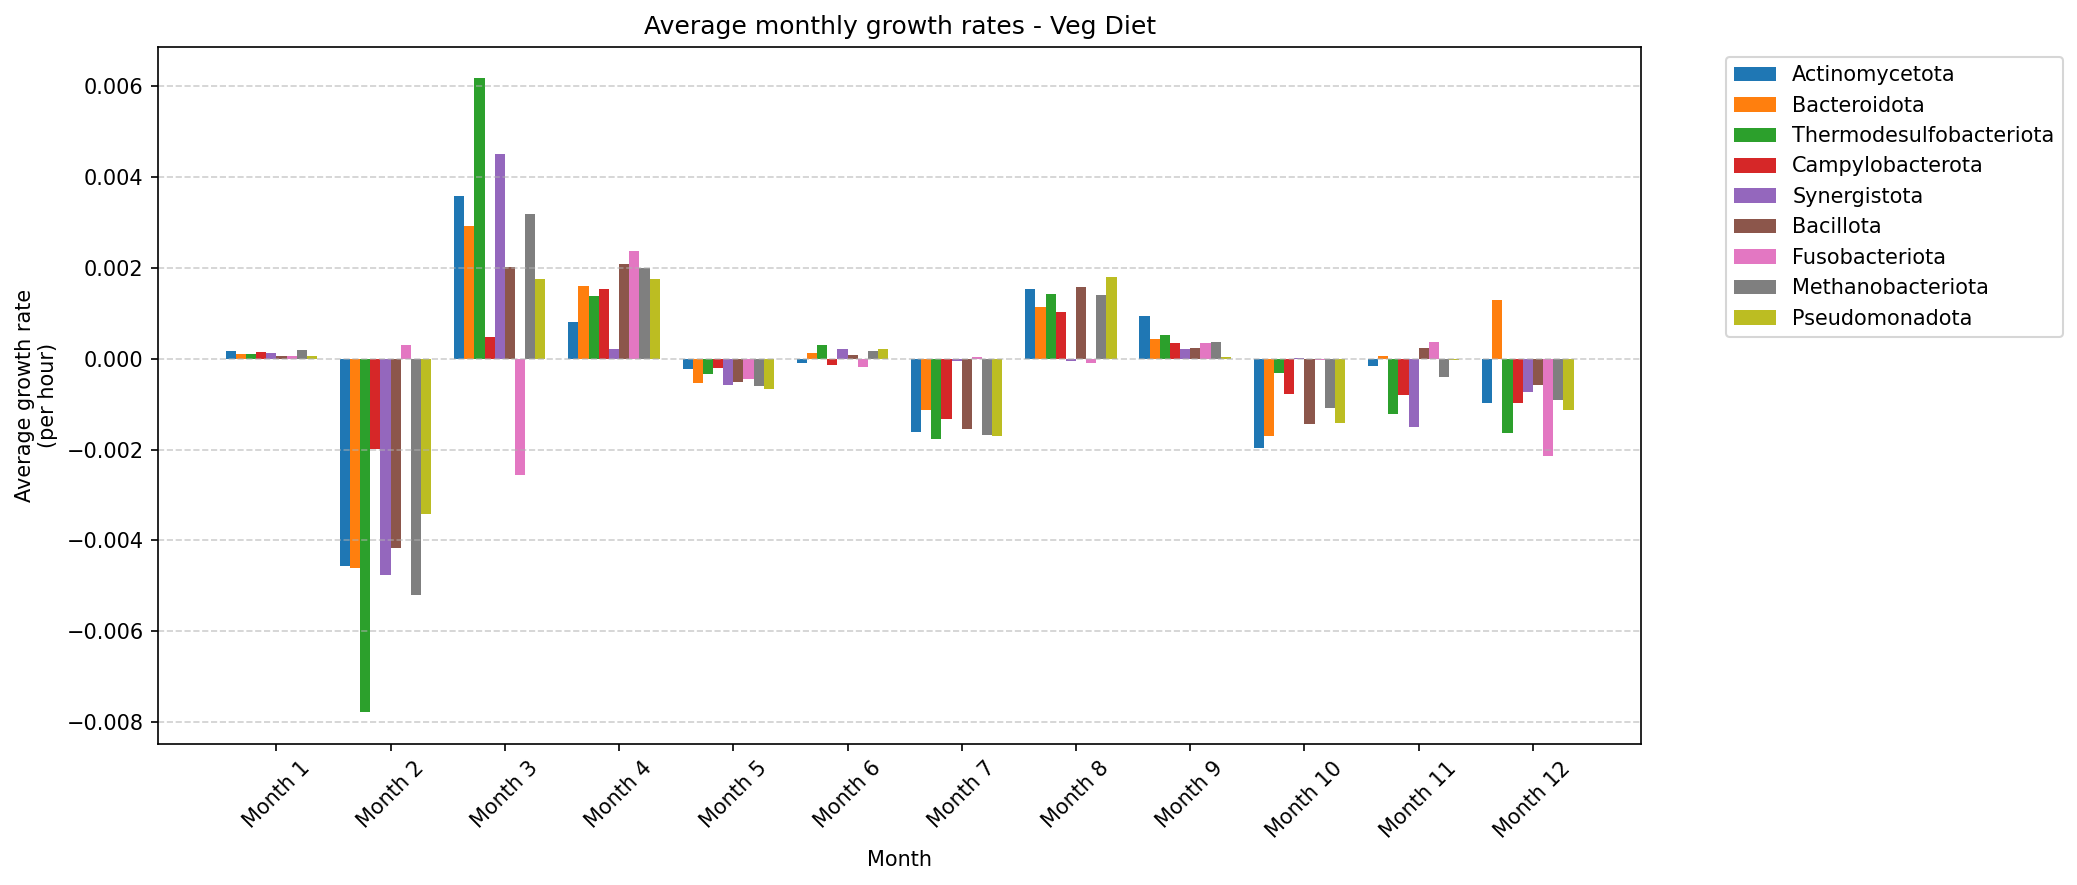

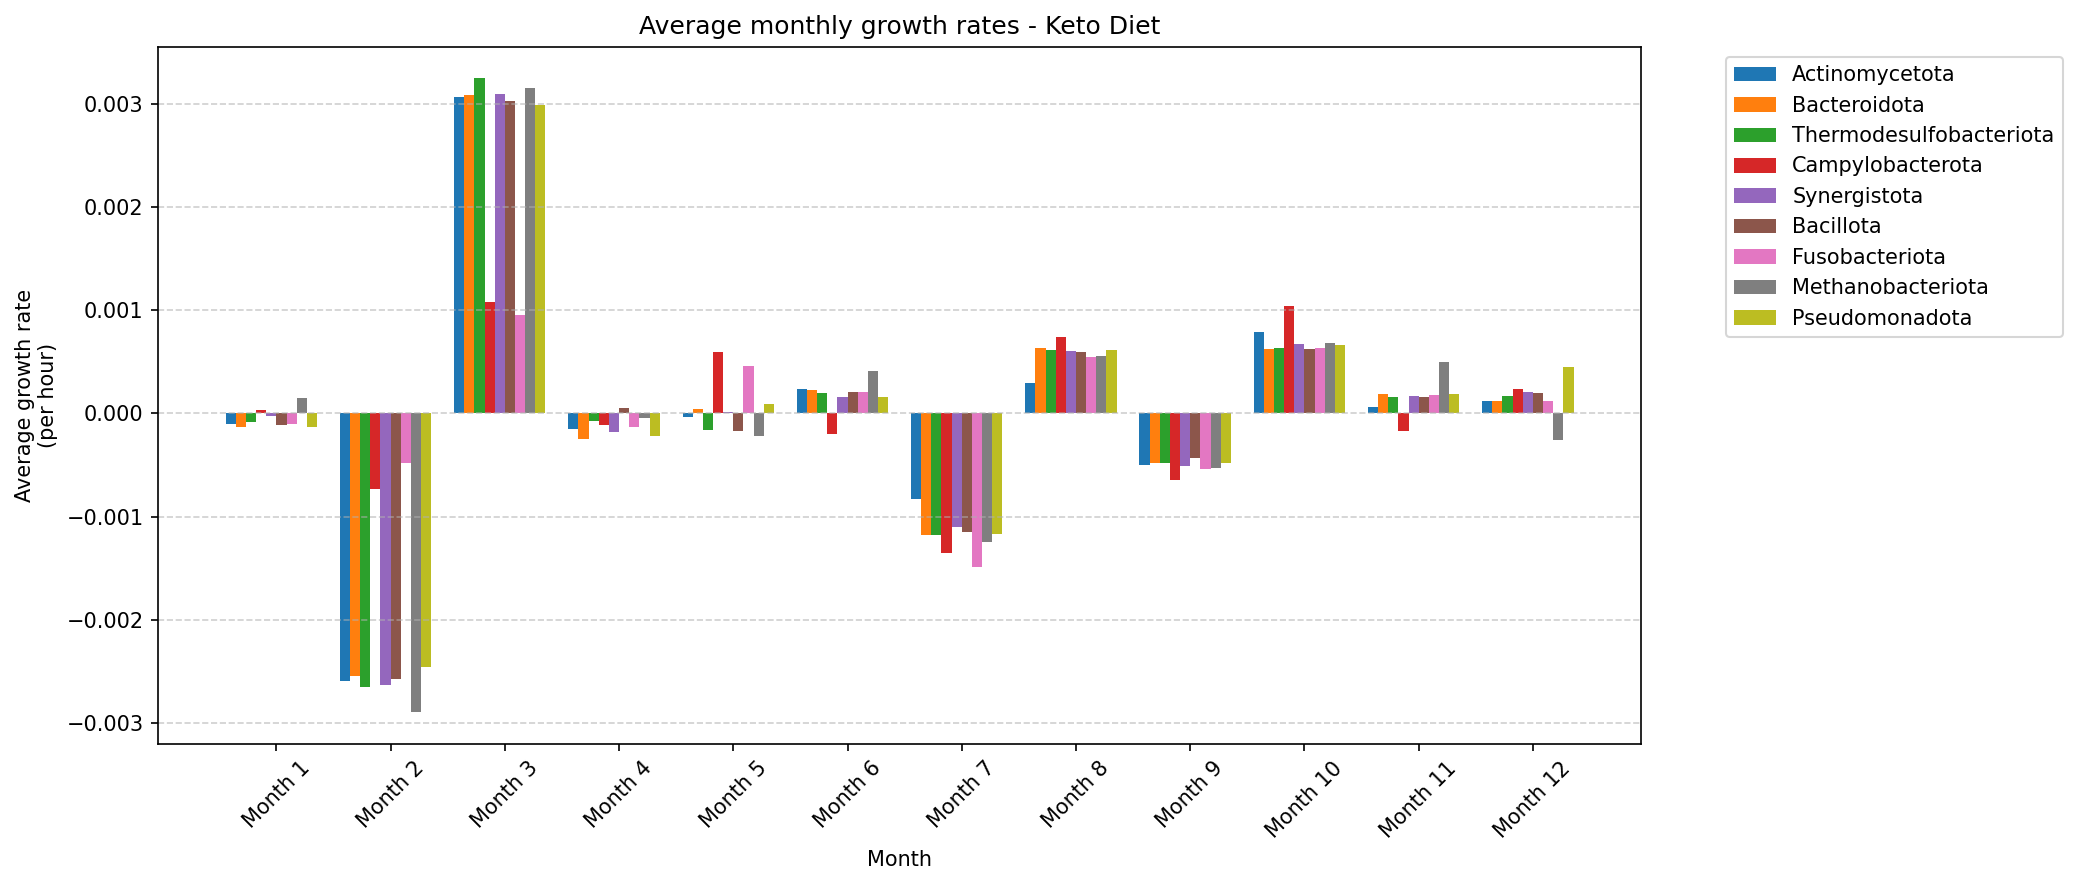

In [10]:
veg_growth = plot_monthly_growth_rates(micro_veg, "Veg")
keto_growth = plot_monthly_growth_rates(micro_keto, "Keto")

In [11]:
compare_growth_rates(veg_growth, keto_growth)

,Species,Mean Growth (Vegetarian),Mean Growth (Keto),Std. Dev. Growth (Vegetarian),Std. Dev. Growth (Keto),p-value,Significant
0,Campylobacterota,-0.000223,0.000042,0.000964,0.000711,0.471429,False
1,Pseudomonadota,-0.000229,0.000057,0.001502,0.001214,0.628622,False
2,Fusobacteriota,-0.000164,0.000029,0.001189,0.000623,0.639593,False
3,Actinomycetota,-0.000219,0.000029,0.001927,0.001222,0.722394,False
4,Synergistota,-0.000199,0.000039,0.001949,0.001255,0.736783,False
5,Methanobacteriota,-0.000214,0.000020,0.002004,0.001336,0.749915,False
6,Bacillota,-0.000162,0.000035,0.001659,0.001229,0.754929,False
7,Thermodesulfobacteriota,-0.000262,0.000034,0.003023,0.001294,0.769113,False
8,Bacteroidota,-0.000021,0.000029,0.001829,0.001245,0.940520,False


In [12]:
def phylum_interactions(growth_df, diet_name):

    corr_matrix = growth_df.T.corr() 
    
    fig, ax = plt.subplots(figsize=(12, 10), dpi=150)

    max_corr = np.max(np.abs(corr_matrix.values))
    norm = Normalize(vmin=-1, vmax=1)
    
    im = ax.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', norm=norm)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, label="Correlation")

    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center')

    ax.set_xticks(np.arange(corr_matrix.shape[1]))
    ax.set_yticks(np.arange(corr_matrix.shape[0]))
    ax.set_xticklabels(corr_matrix.columns, rotation=90)
    ax.set_yticklabels(corr_matrix.index)

    ax.set_title(f"Phylum Interactions - {diet_name} Diet", fontsize=16)

    plt.tight_layout()
    plt.show()

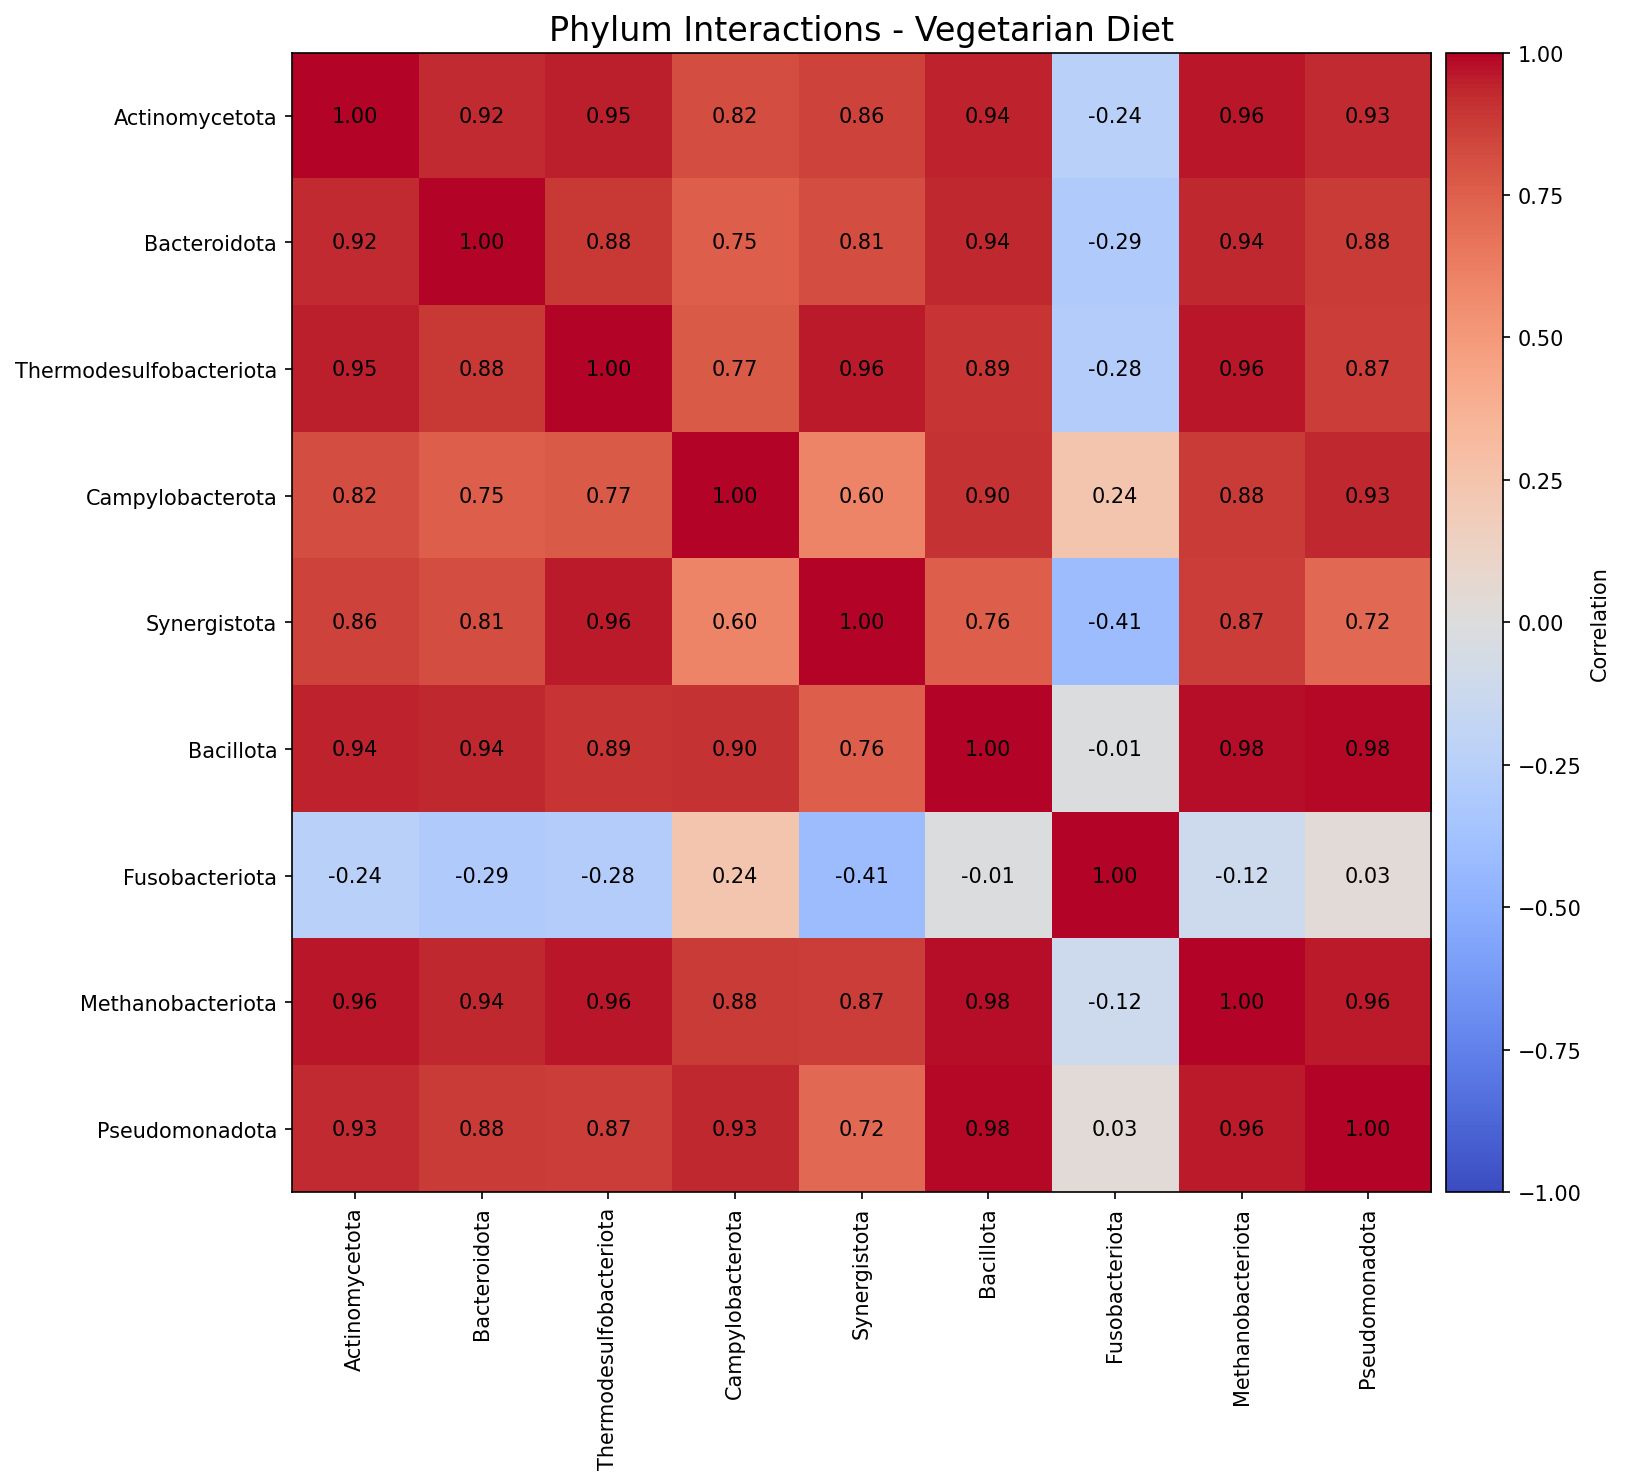

In [13]:
phylum_interactions(veg_growth, "Vegetarian")

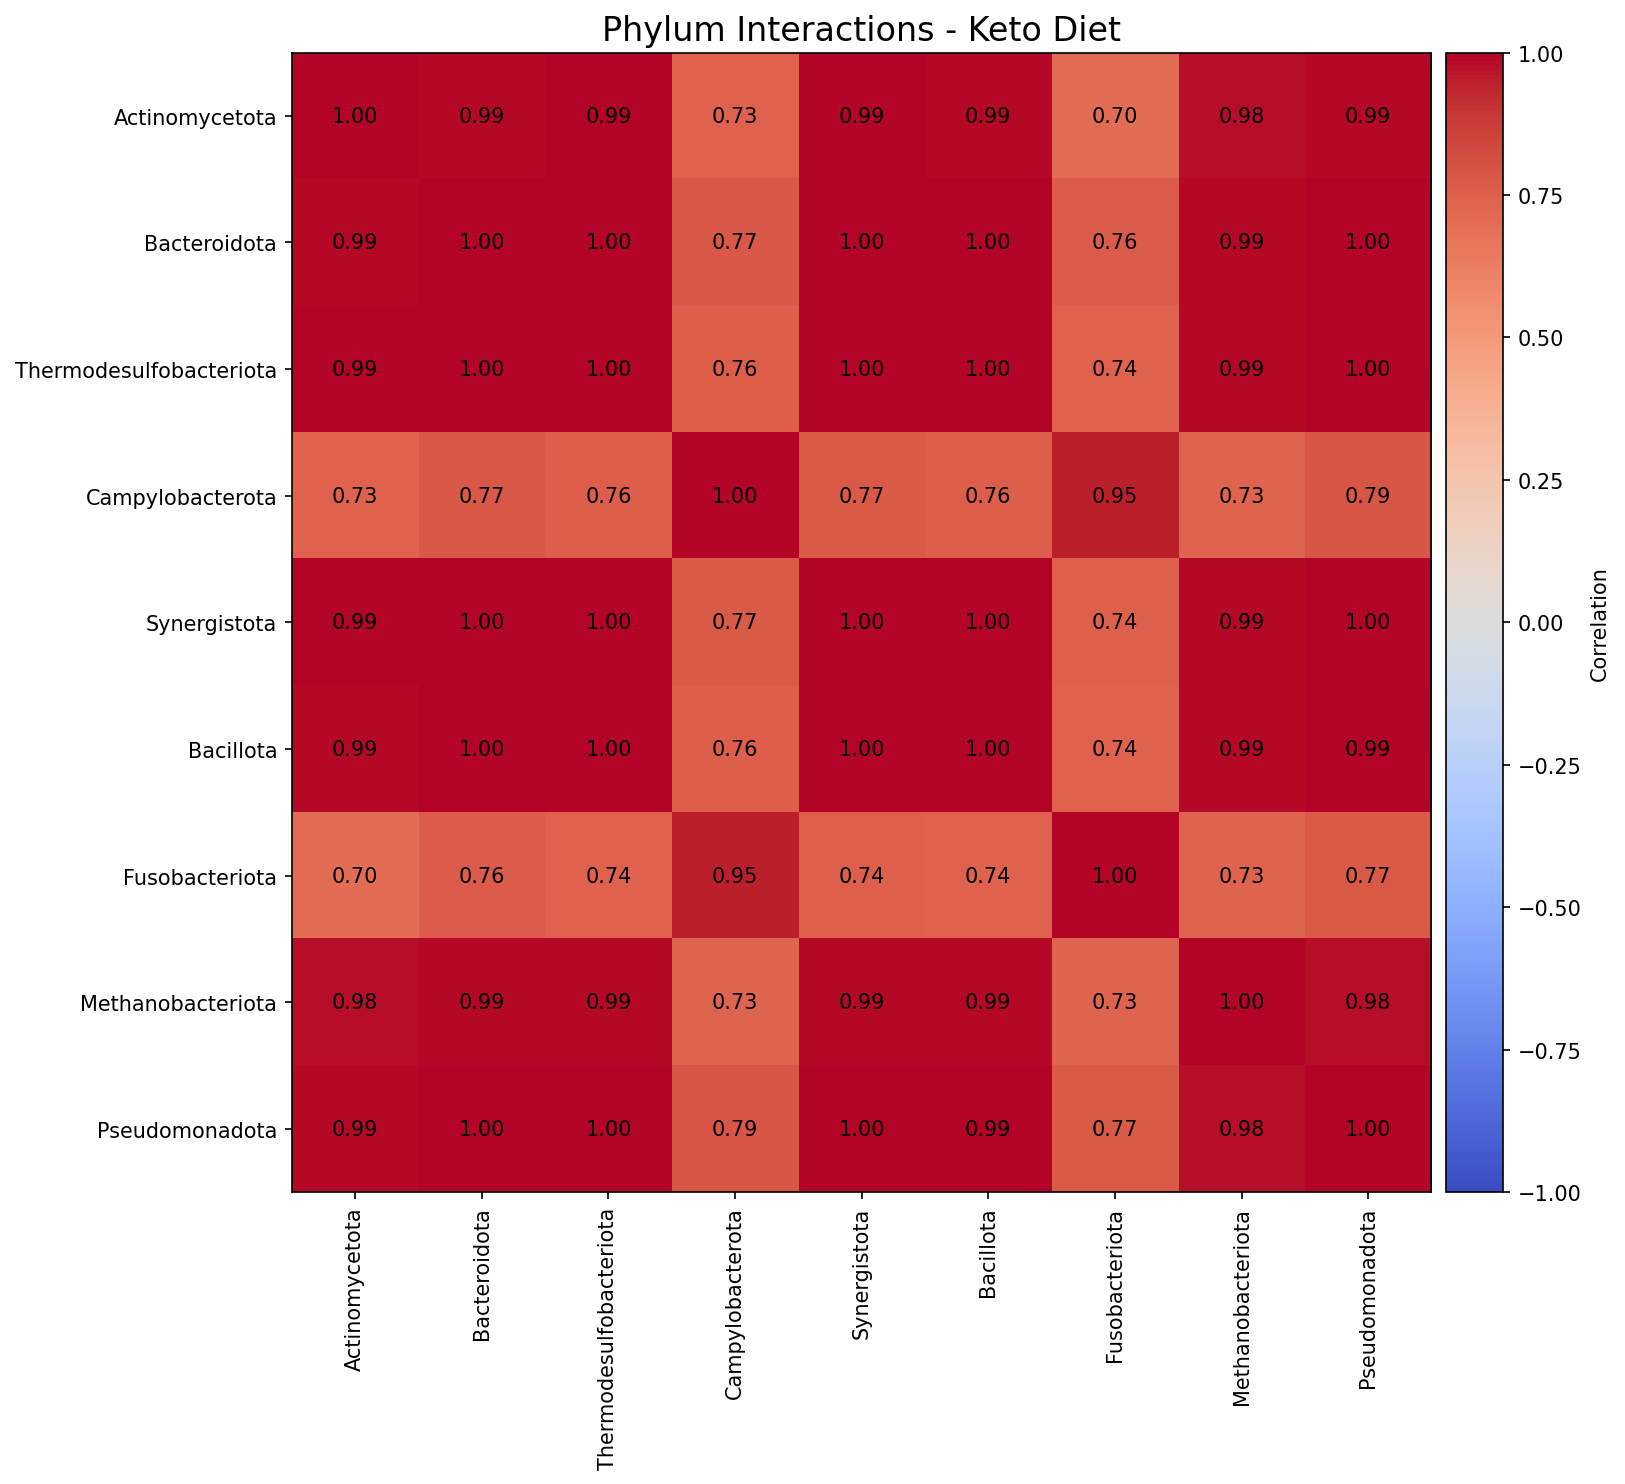

In [14]:
phylum_interactions(keto_growth, "Keto")

In [15]:
diet_veg = pd.read_csv("vegetarian_diet.csv")["Metabolite ID"].tolist()
diet_keto = pd.read_csv("keto_diet.csv")["Metabolite ID"].tolist()

In [16]:
def unique_metabolites(veg_df, keto_df, veg_diet_composition, keto_diet_composition):
    
    veg_present = veg_df.index
    keto_present = keto_df.index

    only_veg = set(veg_present) - set(keto_present)
    only_keto = set(keto_present) - set(veg_present)

    only_veg_exclusive = sorted(only_veg - set(veg_diet_composition))
    only_keto_exclusive = sorted(only_keto - set(keto_diet_composition))

    return {
        'Only in Vegetarian': only_veg_exclusive,
        'Only in Keto': only_keto_exclusive
    }

In [17]:
unique_metabolites(meta_veg, meta_keto, diet_veg, diet_keto)

{'Only in Vegetarian': ['12ppd_S[e]',
  'Rtotal[e]',
  'bilirub[e]',
  'c8crn[e]',
  'gbside_hs[e]',
  'glyb[e]'],
 'Only in Keto': ['oagt3_hs[e]', 'strch2[e]', 'xyl_D[e]']}

In [18]:
def compare_metabolite_amounts(metab_df_veg, metab_df_keto, veg_diet_composition, keto_diet_composition, alpha=0.05, plot=True, n=3): 
    common_metabolites = metab_df_veg.index.intersection(metab_df_keto.index)
    metab_veg = metab_df_veg.loc[common_metabolites]
    metab_keto = metab_df_keto.loc[common_metabolites]

    stats = []
    for metab in common_metabolites:
        veg_vals = metab_veg.loc[metab].values
        keto_vals = metab_keto.loc[metab].values
        t_stat, p_val = ttest_ind(veg_vals, keto_vals, equal_var=False)

        mean_veg = np.mean(veg_vals)
        mean_keto = np.mean(keto_vals)
        fold_change = (mean_veg + 1e-9) / (mean_keto + 1e-9)

        stats.append({
            'Metabolite': metab,
            'Mean Amount (Vegetarian)': mean_veg,
            'Mean Amount (Keto)': mean_keto,
            'Std. Dev. Amount (Vegetarian)': np.std(veg_vals),
            'Std. Dev. Amount (Keto)': np.std(keto_vals),
            'p-value': p_val,
            'Fold Change (Veg/Keto)': fold_change,
            'Significant': p_val < alpha
        })

    results_df = pd.DataFrame(stats)

    results_df['Higher In'] = results_df.apply(
        lambda row: 'Vegetarian' if row['Mean Amount (Vegetarian)'] > row['Mean Amount (Keto)'] else 'Keto',
        axis=1
    )

    significant = results_df[
        (results_df['Significant']) &
        (~results_df['Metabolite'].isin(veg_diet_composition)) &
        (~results_df['Metabolite'].isin(keto_diet_composition))
    ]

    significant = significant.sort_values(
        by=['p-value', 'Fold Change (Veg/Keto)'],
        ascending=[True, False],
        key=lambda x: x if x.name != 'Fold Change (Veg/Keto)' else np.abs(np.log2(x))
    )

    significant_veg = significant[significant['Higher In'] == 'Vegetarian']
    significant_keto = significant[significant['Higher In'] == 'Keto']
    
    significant_keto["Fold Change (Veg/Keto)"] = significant_keto["Fold Change (Veg/Keto)"].apply(lambda x: 1/x)
    significant_keto = significant_keto.rename(columns={"Fold Change (Veg/Keto)":"Fold Change (Keto/Veg)"})

    if plot:
        timepoints = metab_df_veg.columns.astype(int)

        for group, df, colour, title in [
            ('Vegetarian', significant_veg, 'green', f'Top {n} Metabolites Higher in Vegetarian Diet'),
            ('Keto', significant_keto, 'purple', f'Top {n} Metabolites Higher in Keto Diet')
        ]:
            if df.empty:
                continue
            top_n = df.head(n)['Metabolite'].tolist()
            fig, axs = plt.subplots(len(top_n), 1, figsize=(4, 2 * len(top_n)), dpi=150, sharex=True)
            if len(top_n) == 1:
                axs = [axs] 

            for i, metab in enumerate(top_n):
                axs[i].plot(timepoints, metab_veg.loc[metab], label='Vegetarian', color='green')
                axs[i].plot(timepoints, metab_keto.loc[metab], label='Keto', color='purple')
                axs[i].set_title(f"{metab}")
                axs[i].set_ylabel("Amount (mmol)")
                axs[i].grid(alpha=0.4)
                axs[i].legend()

            axs[-1].set_xlabel("Time (hours)")
            plt.suptitle(title, fontsize=14)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

    return significant_veg.reset_index(drop=True), significant_keto.reset_index(drop=True)

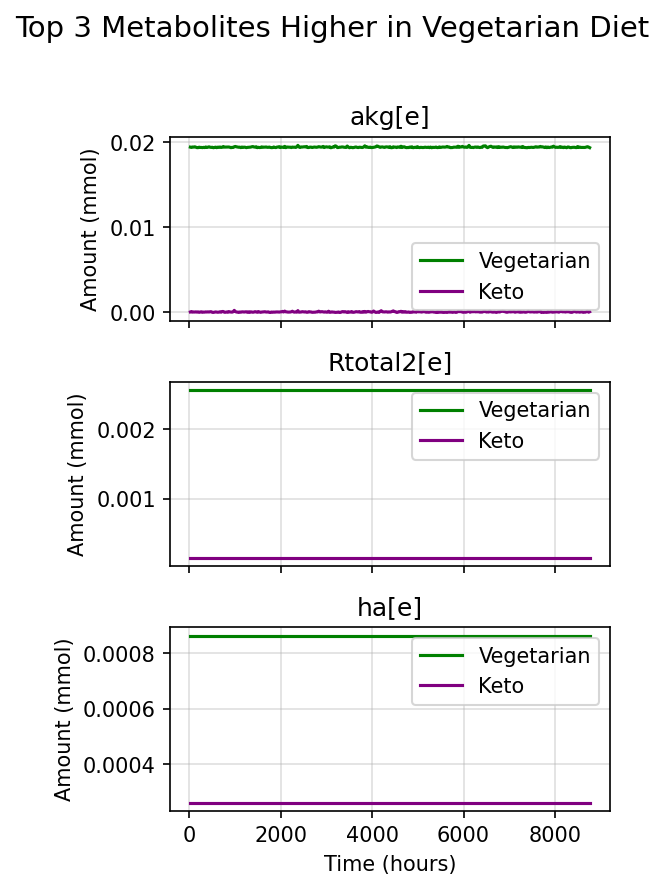

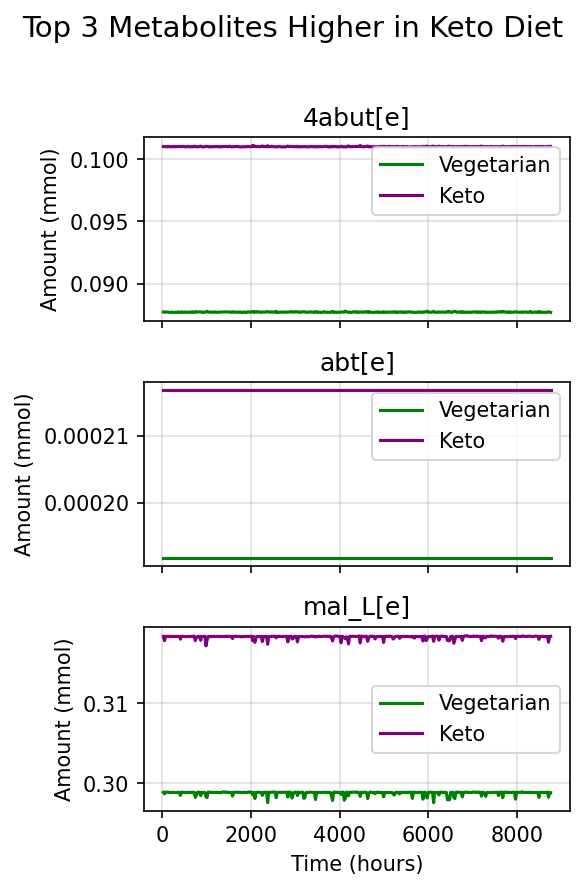

In [19]:
significant_metabs_veg, significant_metabs_keto = compare_metabolite_amounts(meta_veg, meta_keto, diet_veg, diet_keto, n=3)

In [20]:
significant_metabs_veg

,Metabolite,Mean Amount (Vegetarian),Mean Amount (Keto),Std. Dev. Amount (Vegetarian),Std. Dev. Amount (Keto),p-value,Fold Change (Veg/Keto),Significant,Higher In
0,akg[e],1.943594e-02,6.703134e-05,4.473858e-05,3.773675e-05,0.000000e+00,289.948690,True,Vegetarian
1,Rtotal2[e],2.560000e-03,1.488062e-04,8.673617e-19,2.710505e-20,0.000000e+00,17.203474,True,Vegetarian
2,ha[e],8.632476e-04,2.621148e-04,1.084202e-19,0.000000e+00,0.000000e+00,3.293387,True,Vegetarian
3,gua[e],4.222817e-03,1.396404e-03,1.049052e-08,2.792390e-08,0.000000e+00,3.024063,True,Vegetarian
4,so4[e],5.754248e-04,2.847043e-04,3.782644e-08,3.533240e-08,0.000000e+00,2.021128,True,Vegetarian
5,acetone[e],4.207745e-03,2.641077e-03,8.673617e-19,4.336809e-19,0.000000e+00,1.593193,True,Vegetarian
6,HC01444[e],1.013820e-02,6.464705e-03,2.097470e-17,0.000000e+00,0.000000e+00,1.568239,True,Vegetarian
7,orn[e],5.740185e-02,4.331295e-02,8.207844e-06,7.908540e-06,0.000000e+00,1.325281,True,Vegetarian
8,acald[e],2.157985e-02,1.875325e-02,3.943218e-07,4.743343e-08,0.000000e+00,1.150726,True,Vegetarian
9,elaid[e],7.200499e-02,6.911653e-02,3.350886e-17,1.016955e-17,0.000000e+00,1.041791,True,Vegetarian


In [21]:
significant_metabs_keto

,Metabolite,Mean Amount (Vegetarian),Mean Amount (Keto),Std. Dev. Amount (Vegetarian),Std. Dev. Amount (Keto),p-value,Fold Change (Keto/Veg),Significant,Higher In
0,4abut[e],8.771952e-02,1.010068e-01,2.044348e-05,1.877694e-05,0.000000e+00,1.151475,True,Keto
1,abt[e],1.918328e-04,2.167879e-04,5.421011e-20,0.000000e+00,0.000000e+00,1.130087,True,Keto
2,mal_L[e],2.987859e-01,3.182322e-01,2.312980e-04,1.893164e-04,0.000000e+00,1.065084,True,Keto
3,ac[e],2.817385e-01,2.964270e-01,5.023033e-05,2.686901e-05,0.000000e+00,1.052135,True,Keto
4,leuktrA4[e],2.052686e-01,2.127252e-01,3.274430e-17,5.695617e-17,0.000000e+00,1.036326,True,Keto
5,nh4[e],5.758634e-01,5.966693e-01,7.437363e-05,7.139753e-05,0.000000e+00,1.036130,True,Keto
6,succ[e],3.590543e-01,3.651162e-01,2.259234e-04,1.930053e-04,0.000000e+00,1.016883,True,Keto
7,mqn8[e],6.215228e-09,2.047290e-08,5.645290e-09,1.052197e-08,1.074536e-81,2.976053,True,Keto


In [22]:
def correlate_species_metabolites(species_df_veg, species_df_keto, metab_df_veg, metab_df_keto, threshold=0, n=5):
    def compute_correlations(species_df, metab_df, diet_name):
        species = species_df.index
        metabolites = metab_df.index
        correlations = []

        for sp in species:
            for metab in metabolites:
                sp_vals = species_df.loc[sp].values
                metab_vals = metab_df.loc[metab].values

                if np.std(sp_vals) == 0 or np.std(metab_vals) == 0:
                    corr = np.nan  
                else:
                    corr, _ = pearsonr(sp_vals, metab_vals)

                correlations.append({
                    'Species': sp,
                    'Metabolite': metab,
                    'Correlation': corr,
                    'Diet': diet_name
                })

        corr_df = pd.DataFrame(correlations)
        corr_df['abs_Correlation'] = corr_df['Correlation'].abs()  
        corr_df = corr_df[corr_df['abs_Correlation'] >= threshold]  
        return corr_df.reset_index(drop=True)

    corr_veg = compute_correlations(species_df_veg, metab_df_veg, 'Vegetarian')
    corr_keto = compute_correlations(species_df_keto, metab_df_keto, 'Keto')

    merged_corr = pd.merge(corr_veg[['Species', 'Metabolite', 'Correlation']].rename(columns={'Correlation': 'Correlation_Veg'}),
                           corr_keto[['Species', 'Metabolite', 'Correlation']].rename(columns={'Correlation': 'Correlation_Keto'}),
                           on=['Species', 'Metabolite'])

    merged_corr['Corr_Diff'] = merged_corr['Correlation_Veg'] - merged_corr['Correlation_Keto']
    merged_corr['abs_Corr_Diff'] = merged_corr['Corr_Diff'].abs()

    top_n_corr_diff = merged_corr.sort_values(by='abs_Corr_Diff', ascending=False)
    top_n_metabolites = top_n_corr_diff.drop_duplicates(subset='Metabolite').head(n)['Metabolite']

    heatmap_data_veg = corr_veg[corr_veg['Metabolite'].isin(top_n_metabolites)].pivot(index='Species', columns='Metabolite', values='Correlation')
    heatmap_data_keto = corr_keto[corr_keto['Metabolite'].isin(top_n_metabolites)].pivot(index='Species', columns='Metabolite', values='Correlation')

    fig, (ax_veg, ax_keto) = plt.subplots(1, 2, figsize=(18, 10), dpi=150)

    max_corr_veg = np.max(np.abs(heatmap_data_veg.values))
    norm_veg = Normalize(vmin=-1, vmax=1)
    im_veg = ax_veg.imshow(heatmap_data_veg, cmap='coolwarm', interpolation='nearest', norm=norm_veg)

    divider_veg = make_axes_locatable(ax_veg)
    cax_veg = divider_veg.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im_veg, cax=cax_veg, label="Correlation")

    for i in range(heatmap_data_veg.shape[0]):
        for j in range(heatmap_data_veg.shape[1]):
            ax_veg.text(j, i, f'{heatmap_data_veg.iloc[i, j]:.2f}', ha='center', va='center')

    ax_veg.set_xticks(np.arange(heatmap_data_veg.shape[1]))
    ax_veg.set_yticks(np.arange(heatmap_data_veg.shape[0]))
    ax_veg.set_xticklabels(heatmap_data_veg.columns, rotation=90)
    ax_veg.set_yticklabels(heatmap_data_veg.index)
    ax_veg.set_title("Vegetarian")

    max_corr_keto = np.max(np.abs(heatmap_data_keto.values))
    norm_keto = Normalize(vmin=-1, vmax=1)
    im_keto = ax_keto.imshow(heatmap_data_keto, cmap='coolwarm', interpolation='nearest', norm=norm_keto)

    divider_keto = make_axes_locatable(ax_keto)
    cax_keto = divider_keto.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im_keto, cax=cax_keto, label="Correlation")

    for i in range(heatmap_data_keto.shape[0]):
        for j in range(heatmap_data_keto.shape[1]):
            ax_keto.text(j, i, f'{heatmap_data_keto.iloc[i, j]:.2f}', ha='center', va='center')

    ax_keto.set_xticks(np.arange(heatmap_data_keto.shape[1]))
    ax_keto.set_yticks(np.arange(heatmap_data_keto.shape[0]))
    ax_keto.set_xticklabels(heatmap_data_keto.columns, rotation=90)
    ax_keto.set_yticklabels(heatmap_data_keto.index)
    ax_keto.set_title("Keto")
    
    plt.suptitle(f"Top {n} Metabolites with Significant Correlation Differences", fontsize=1)
    plt.tight_layout()
    plt.show()

    return top_n_corr_diff

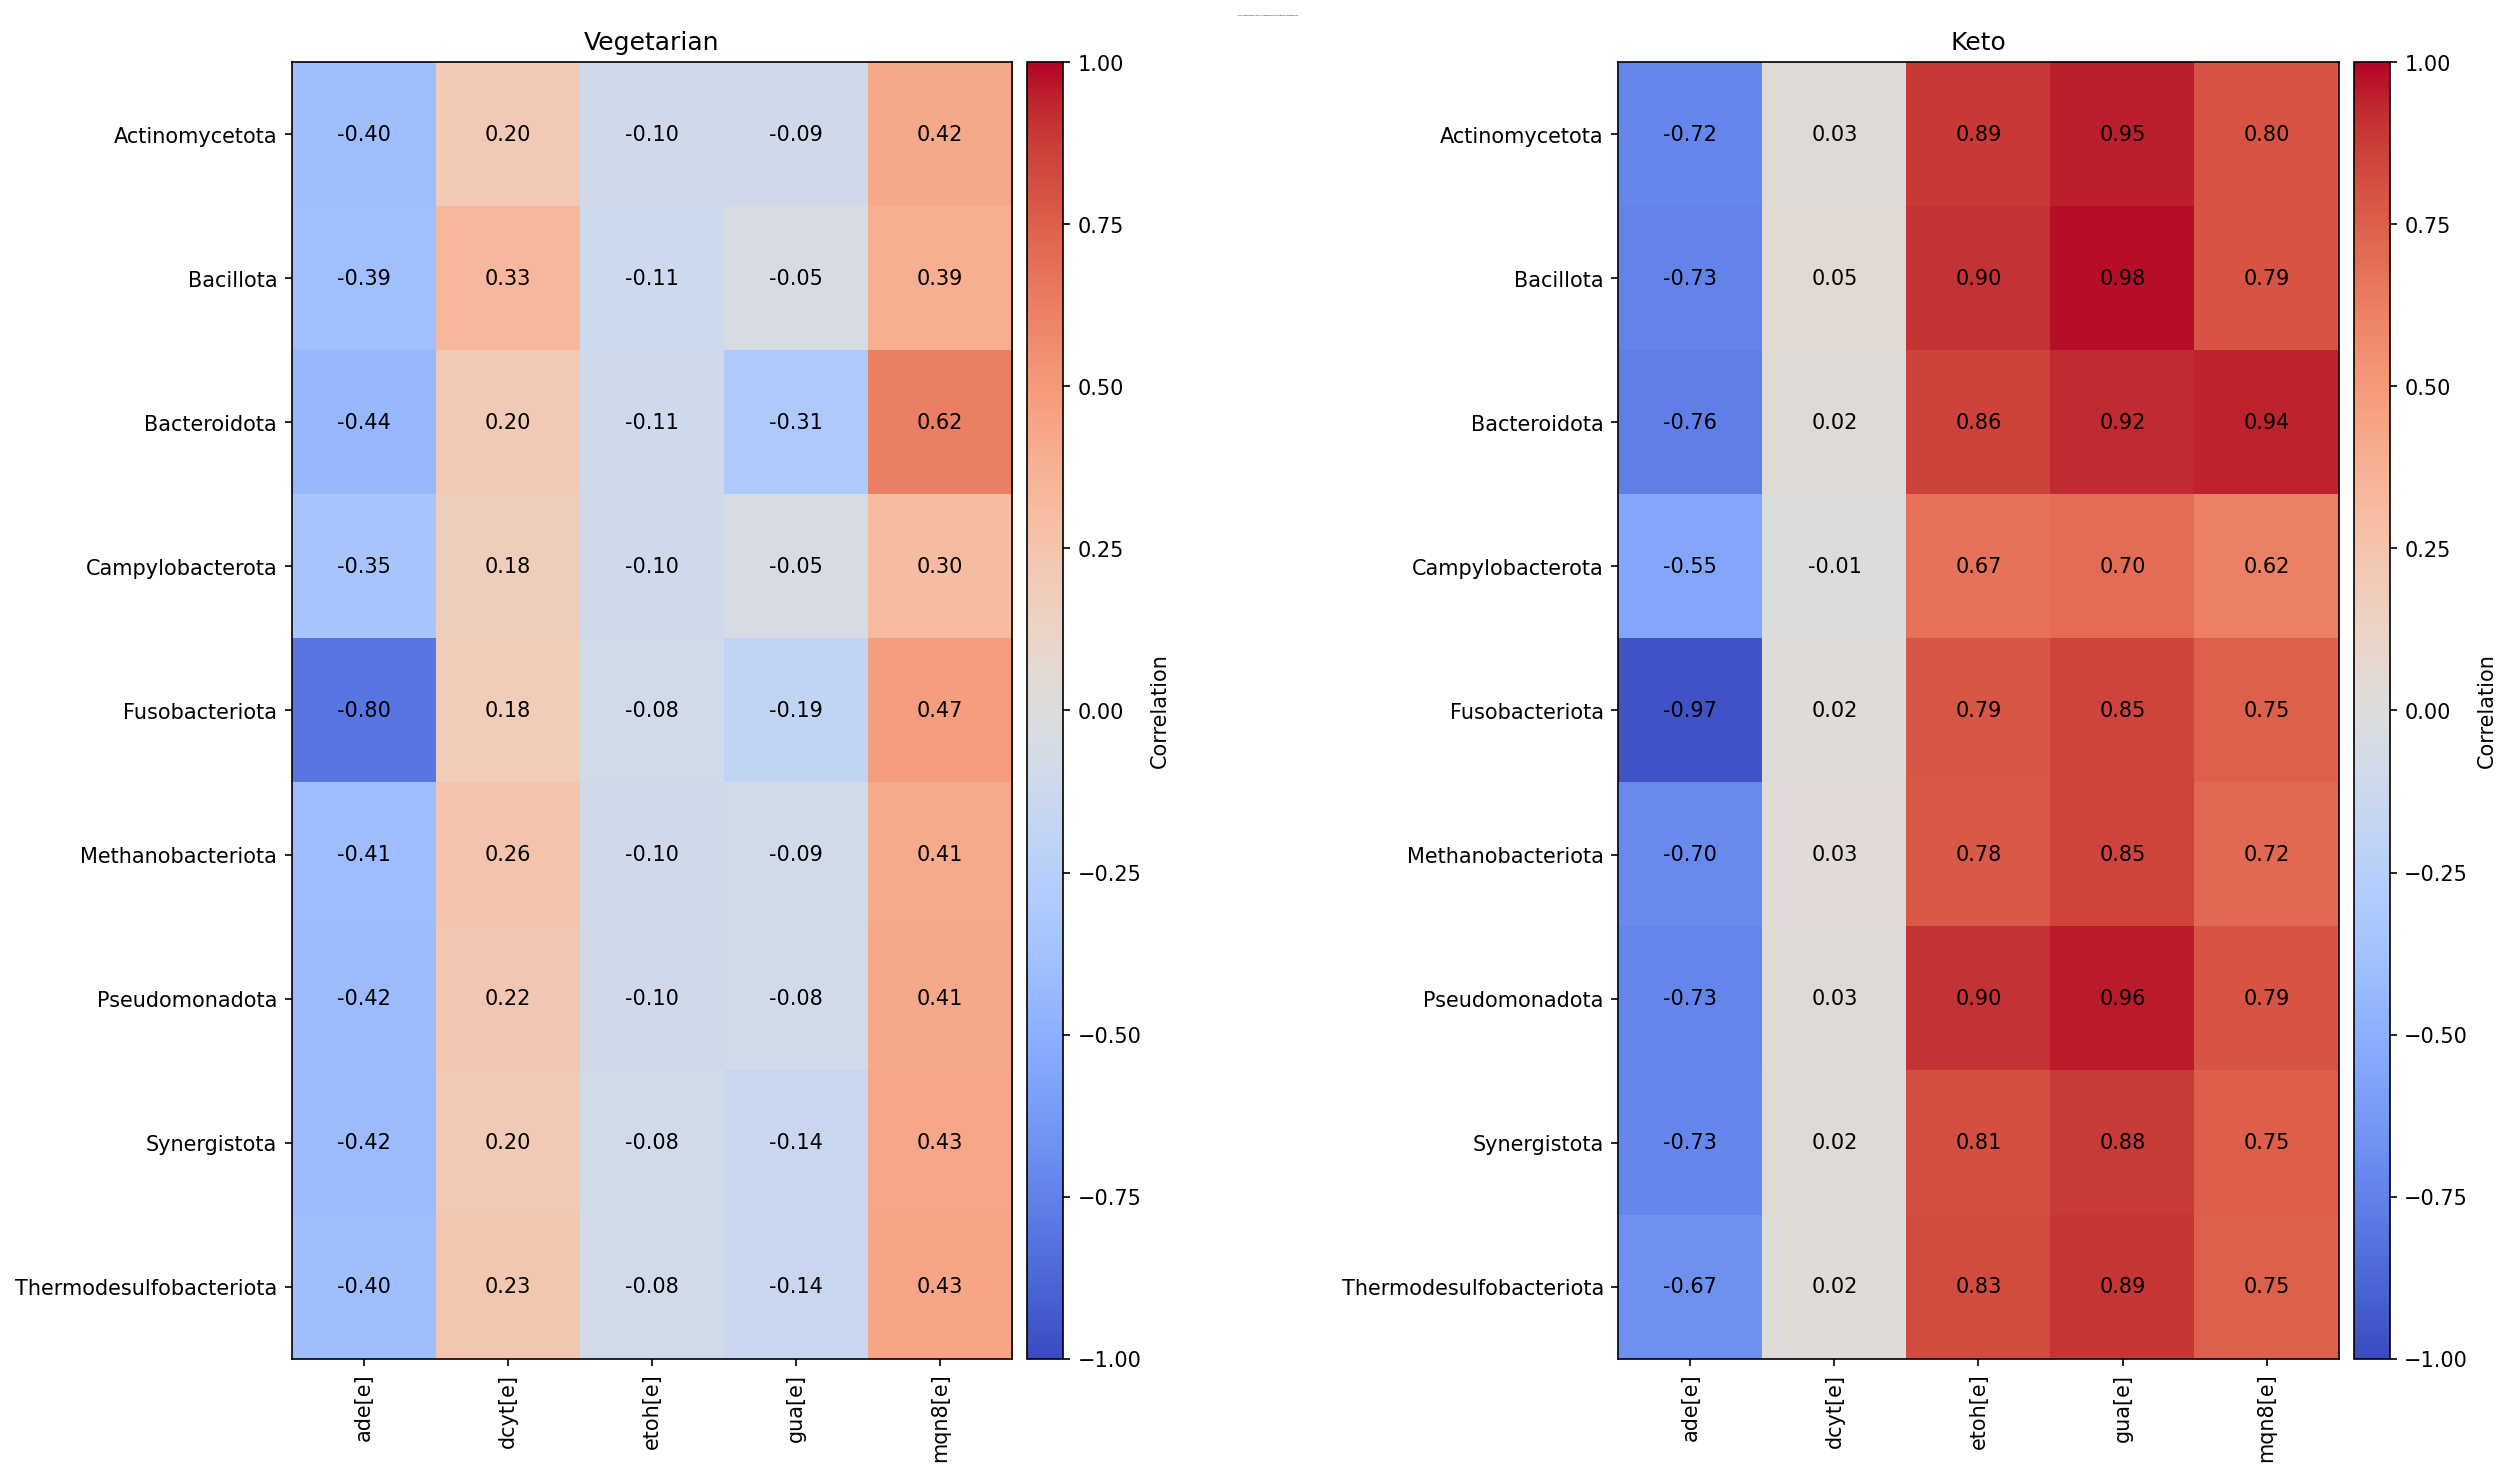

In [23]:
top_n_corr_diff = correlate_species_metabolites(micro_veg, micro_keto, meta_veg, meta_keto)

In [24]:
top_n_corr_diff

,Species,Metabolite,Correlation_Veg,Correlation_Keto,Corr_Diff,abs_Corr_Diff
178,Bacteroidota,gua[e],-0.310896,0.924134,-1.235029,1.235029
53,Actinomycetota,gua[e],-0.094730,0.947908,-1.042638,1.042638
803,Fusobacteriota,gua[e],-0.193660,0.847836,-1.041496,1.041496
1053,Pseudomonadota,gua[e],-0.084339,0.955784,-1.040123,1.040123
303,Thermodesulfobacteriota,gua[e],-0.135453,0.891427,-1.026880,1.026880
...,...,...,...,...,...,...
972,Methanobacteriota,ptdca[e],0.026136,0.025818,0.000318,0.000318
546,Synergistota,fum[e],0.026859,0.027159,-0.000300,0.000300
1008,Pseudomonadota,acald[e],0.201607,0.201883,-0.000276,0.000276
725,Bacillota,pydxn[e],0.024736,0.024876,-0.000140,0.000140


In [25]:
def find_high_variance_metabolites(species_df_veg, species_df_keto, metab_df_veg, metab_df_keto, threshold=0, top_n=5):
    def compute_correlations(species_df, metab_df, diet_name):
        species = species_df.index
        metabolites = metab_df.index
        correlations = []

        for sp in species:
            for metab in metabolites:
                sp_vals = species_df.loc[sp].values
                metab_vals = metab_df.loc[metab].values

                if np.std(sp_vals) == 0 or np.std(metab_vals) == 0:
                    corr = np.nan  
                else:
                    corr, _ = pearsonr(sp_vals, metab_vals)

                correlations.append({
                    'Species': sp,
                    'Metabolite': metab,
                    'Correlation': corr,
                    'Diet': diet_name
                })

        corr_df = pd.DataFrame(correlations)
        corr_df['abs_Correlation'] = corr_df['Correlation'].abs()  
        corr_df = corr_df[corr_df['abs_Correlation'] >= threshold]  
        return corr_df.reset_index(drop=True)

    corr_veg = compute_correlations(species_df_veg, metab_df_veg, 'Vegetarian')
    corr_keto = compute_correlations(species_df_keto, metab_df_keto, 'Keto')

    def compute_variance_in_correlation(corr_df):
        variance_df = corr_df.groupby('Metabolite')['Correlation'].var().reset_index()
        variance_df = variance_df.rename(columns={'Correlation': 'Variance'})
        variance_df = variance_df.sort_values(by='Variance', ascending=False)
        return variance_df

    variance_veg = compute_variance_in_correlation(corr_veg)
    variance_keto = compute_variance_in_correlation(corr_keto)

    top_n_veg_metabolites = variance_veg.head(top_n)['Metabolite']
    top_n_keto_metabolites = variance_keto.head(top_n)['Metabolite']

    heatmap_data_veg = corr_veg[corr_veg['Metabolite'].isin(top_n_veg_metabolites)].pivot(index='Species', columns='Metabolite', values='Correlation')
    heatmap_data_keto = corr_keto[corr_keto['Metabolite'].isin(top_n_keto_metabolites)].pivot(index='Species', columns='Metabolite', values='Correlation')

    fig, (ax_veg, ax_keto) = plt.subplots(1, 2, figsize=(18, 10), dpi=150)

    max_corr_veg = np.max(np.abs(heatmap_data_veg.values))
    norm_veg = Normalize(vmin=-1, vmax=1)
    im_veg = ax_veg.imshow(heatmap_data_veg, cmap='coolwarm', interpolation='nearest', norm=norm_veg)

    divider_veg = make_axes_locatable(ax_veg)
    cax_veg = divider_veg.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im_veg, cax=cax_veg, label="Correlation")

    for i in range(heatmap_data_veg.shape[0]):
        for j in range(heatmap_data_veg.shape[1]):
            ax_veg.text(j, i, f'{heatmap_data_veg.iloc[i, j]:.2f}', ha='center', va='center')

    ax_veg.set_xticks(np.arange(heatmap_data_veg.shape[1]))
    ax_veg.set_yticks(np.arange(heatmap_data_veg.shape[0]))
    ax_veg.set_xticklabels(heatmap_data_veg.columns, rotation=90)
    ax_veg.set_yticklabels(heatmap_data_veg.index)
    ax_veg.set_title("Vegetarian")

    max_corr_keto = np.max(np.abs(heatmap_data_keto.values))
    norm_keto = Normalize(vmin=-1, vmax=1)
    im_keto = ax_keto.imshow(heatmap_data_keto, cmap='coolwarm', interpolation='nearest', norm=norm_keto)

    divider_keto = make_axes_locatable(ax_keto)
    cax_keto = divider_keto.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im_keto, cax=cax_keto, label="Correlation")

    for i in range(heatmap_data_keto.shape[0]):
        for j in range(heatmap_data_keto.shape[1]):
            ax_keto.text(j, i, f'{heatmap_data_keto.iloc[i, j]:.2f}', ha='center', va='center')

    ax_keto.set_xticks(np.arange(heatmap_data_keto.shape[1]))
    ax_keto.set_yticks(np.arange(heatmap_data_keto.shape[0]))
    ax_keto.set_xticklabels(heatmap_data_keto.columns, rotation=90)
    ax_keto.set_yticklabels(heatmap_data_keto.index)
    ax_keto.set_title("Keto", fontsize=14)
    
    plt.suptitle(f"Top {top_n} Metabolites with Highest Variance in Correlation", fontsize=14)
    plt.tight_layout()
    plt.show()

    return variance_veg, variance_keto

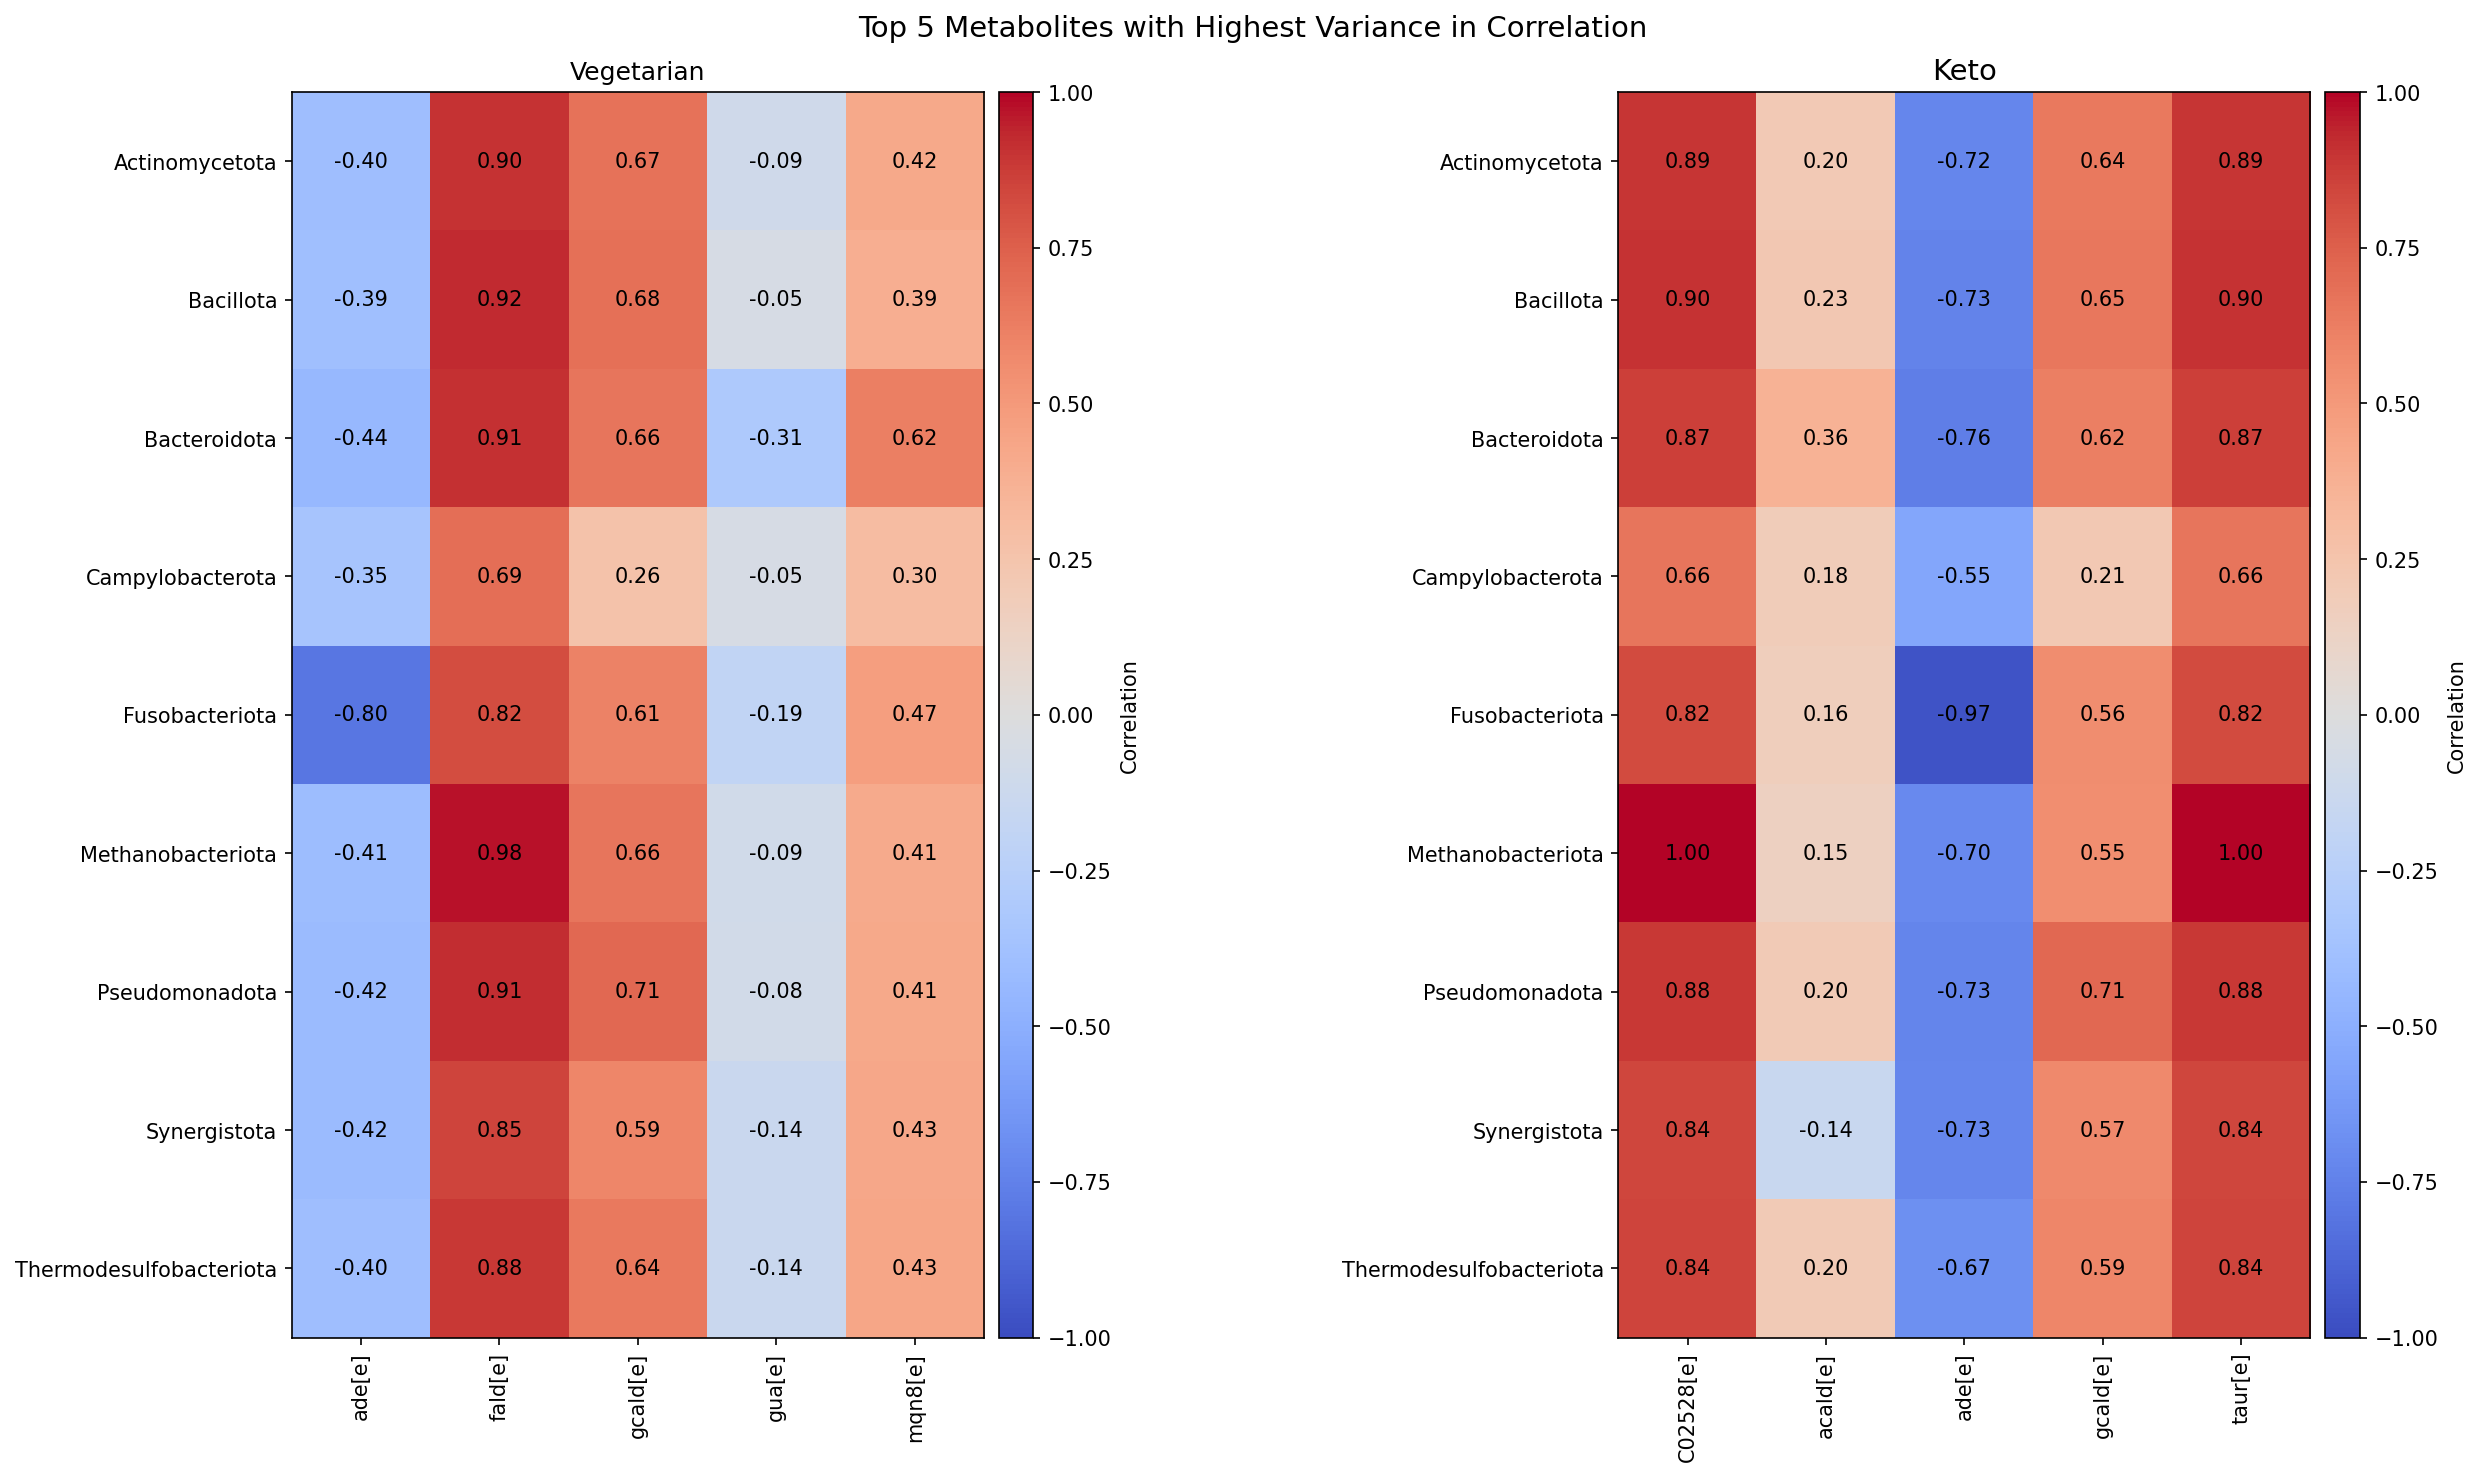

In [26]:
var_veg, var_keto = find_high_variance_metabolites(micro_veg, micro_keto, meta_veg, meta_keto)

In [27]:
var_veg

,Metabolite,Variance
11,ade[e],0.018315
51,gcald[e],0.018280
84,mqn8[e],0.006995
58,gua[e],0.006832
42,fald[e],0.006798
...,...,...
106,pydxn[e],0.000106
0,10fthf[e],0.000076
24,ca2[e],0.000041
72,leuktrA4[e],0.000036


In [28]:
var_keto

,Metabolite,Variance
49,gcald[e],0.020568
8,acald[e],0.017782
9,ade[e],0.011658
113,taur[e],0.007912
4,C02528[e],0.007912
...,...,...
48,fum[e],0.000078
84,ncam[e],0.000074
129,zn2[e],0.000074
119,trp_L[e],0.000065
